#Uso de series difusas para el desarrollo de modelos de predicción de demandas de la energía eléctrica.

**Estudiante: José Manuel Rubio Cienfuegos.**

**Prof. José Miguel Rubio León.**

**Prof coguía: Francisco Rivera.**

El siguiente notebook contiene el sistema encargado de procesar la base de datos que contiene información sobre diversos consumos de energía, además de datos sobre las variables que afectan este consumo de energía.

##Librerías

Esta celda contiene información sobre todas librerías necesarias para el procesamiento de la información y exposición de los resultados obtenidos.

In [104]:
# Procesamiento de datos y gráficos.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelos de ML clásicos.
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.statespace import sarimax
import statsmodels.api as sm

# Métricas
from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error

# Pickle para el guardaddo de variables pesadas.
import pickle

# MAPE Function

def MAPE(y_true, y_pred):
  true_length, pred_length = y_true.__len__(), y_pred.__len__()
  assert true_length == pred_length, ('Lengths of arrays are differents, y_true have ' + str(true_length) + ' values and y_pred have ' + str(pred_length) + ' values.')
  return (100*(sum(abs((y_true - y_pred)/(y_true)))))/(y_true.__len__())

In [105]:
!git clone https://github.com/JossRubio/Prediccion_demanda_energetica

fatal: destination path 'Prediccion_demanda_energetica' already exists and is not an empty directory.


##Carga de datos

Los datos a utilizar se cargan en este bloque. Previo a esto se deben haber subido a la interfaz de colab o habilitar un link de algun servidor para cargarlos de manera remota. En el siguiente bloque se pueden subir los archivos de forma local

Con los archivos subidos, entonces se cargan dentro del notebook

In [106]:
# Extracción de datasets

directory = "Prediccion_demanda_energetica/data/"                   # Directorio donde se almacenan los datasets.
directory_var = 'Prediccion_demanda_energetica/codes/variables/'    # Directorio donde se almacenan las variables de interes.

df_energy = pd.read_csv(directory + "energy_dataset.csv")
df_weather = pd.read_csv(directory + "weather_features.csv")

df_energy['time'] = pd.to_datetime(df_energy['time'], format='%Y-%m-%d %H:%M:%S')
df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'], format='%Y-%m-%d %H:%M:%S')

In [107]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [108]:
df_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


Antes de desarrollar algun modelo, se debe destacar que dentro de los datos ya se cuentan con valores predichos para la demanda. Por ello esta celda indica cual es el **MAPE** (*Mean Absolute Percentage Error*) de los datos pronosticados guardados en el dataset *energy_dataset.csv*

In [109]:
df_demand = df_energy[['total load actual', 'total load forecast']].dropna() # Eliminación de nans presentes en la columna de valores de la demanda.
demand_total, demand_forecast = df_demand['total load actual'], df_demand['total load forecast']

# MAPE de los valores predichos en la demanda del dataset original.
MAPE_goal = MAPE(demand_total.values, demand_forecast.values)
print('The MAPE of the work is:', round(MAPE_goal, 3), '%') 

The MAPE of the work is: 1.096 %


In [110]:
df_energy.shape

(35064, 29)

In [111]:
''' ANALIZAR SI LOS VALORES DE GENERACIÓN DE DISTINTOS TIPOS DE ENERGÍA EQUIVALE A LA DEMANDA TOTAL MOSTRADA EN EL DATASET. '''
# Suma de valores de la columna del dataset de energia (energy_dataset.csv)

# En primer lugar se quieren eliminar aquellas columnas que en su mayoría poseen valores nans. Para ello se diseña la siguiente función

def nans_remove(df, nan_threshold, reset_index=True):
  df_process = df.copy()
  assert nan_threshold < 1 and nan_threshold > 0 , ('nan threshold must be between 0 and 1')
  cols_names = df.columns
  for name in cols_names:
    len, drop_len = df_process[name].__len__(), df_process[name].dropna().__len__()
    difference_reason = (len - drop_len)/(len)
    if difference_reason > (1-nan_threshold):
      df_process.drop(columns=[name], inplace=True)
    else:
      continue
  df_process.dropna(inplace=True)
  df_process.reset_index(drop=reset_index, inplace=reset_index)
  return df_process

nan_limit = .9

# Eliminando las columnas nans del dataframe se tiene.
df_energy_processed = nans_remove(df_energy, nan_limit)

# Obteniendo las columnas que solo poseen valores de generación
columns_drop = ['forecast solar day ahead', 'forecast wind onshore day ahead','price day ahead', 'price actual']
columns_demand = ['total load actual', 'total load forecast']
demand_data, time_data = df_energy_processed[columns_demand], df_energy_processed['time']

# df_generation = df_energy_processed.drop(columns=columns_drop + columns_demand)
# generation_values = df_generation.values

# # Sumando los valores numericos del dataframe procesado, y añadiendo la columna al dataframe original
# generation_total = df_generation.sum(axis=1, numeric_only=True)
# generation_total.name = 'Generation total'

# df_gen_dem = pd.concat([time_data, demand_data, generation_total], axis=1)

In [112]:
# columns_show = ['time', 'total load actual']

# df_energy_processed[columns_show].plot(x='time', figsize=(15,6), grid=True, ylabel='MW', title='Demanda de energía TSO España')

## Extracción de variables estocásticas de interes para la demanda de la energía eléctrica.

Una parte importante de este trabajo es la búsqueda de las características que más afectan a la demanda de la energía eléctrica, donde se espera que estas esten presentes dentro de la base de datos. Para ellos se realiza una búsqueda de cuales son las variables que más influyen en los valores presentes en la demanda de la energía.

En primer lugar se calculará la matriz de correlación para cada variable del dataset de energía.

In [113]:
df_correlation = df_energy_processed.corr()          

# Valores de correlación de cada variable respecto a la demanda.
demand_correlation = df_correlation['total load actual'].sort_values(ascending=False)
# Eliminando las relaciones con el pronóstico y la demanda misma
demand_correlation.drop(['total load actual', 'total load forecast'], inplace=True)

n_relations = 5     # Cantidad de variables relacionadas.

variables_relationed = demand_correlation[:n_relations]
variables_relationed_names = list(variables_relationed.index)

In [114]:
# Dataset con los datos de interés (demanda + variables relacionadas)

demand_labels = ['time', 'total load forecast', 'total load actual']
demand_with_relation_names = demand_labels + variables_relationed_names

demand_serie = df_energy_processed[demand_with_relation_names]

## Series Temporales

En esta sección se procesa la información de la base de datos para realizar las predicciones mediante el uso de series temporales clásicas.

In [115]:
# Función para la generación de series temporales, cuyo largo se puede configurar.

def series_constructor(df, len_serie, column_serie, n_data, column_concat_name=None, dropna=True, reset_index=True):
  df_process = df[column_serie]
  df_out = pd.DataFrame() if column_concat_name == None else df[column_concat_name]
  for k in reversed(range(len_serie + 1)):
    serie_moved = df_process.shift(k)
    serie_moved.name = 't-' + str(k)
    df_out = pd.concat([df_out, serie_moved], axis=1)
  df_out.rename(columns={'t-0':'t'}, inplace=True)
  columns_final = list(df_out.columns) if column_concat_name == None else list(df_out.columns)[1:] + [column_concat_name]
  df_out = df_out[columns_final]
  df_out.dropna(inplace=dropna)
  df_out = df_out.iloc[:n_data]
  df_out.reset_index(drop=reset_index, inplace=reset_index)
  return df_out

In [116]:
# Procesamiento de la información de la demanda con la función anterior

length_serie = 72       # Como la serie temporal corresponde a la demanda horaria, entonces el largo será 24.
n_data = demand_serie.__len__()

demand_time_series = series_constructor(demand_serie, length_serie, n_data=n_data, column_serie='total load actual', column_concat_name='time')  # Aplicando la función anterior.

demand_series, data_time = demand_time_series.drop(['time'], axis=1), demand_time_series['time']  # Separando la información en las series y datos del tiempo.

forecast_default = demand_serie[['time','total load forecast']]

# Dataframes para el procesamiento de datos

X_data, y_data = demand_series.drop(['t'], axis=1), demand_series['t']

In [117]:
demand_time_series.head()

,t-72,t-71,t-70,t-69,t-68,t-67,t-66,t-65,t-64,t-63,...,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t,time
0,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,...,24770.0,24501.0,24992.0,27964.0,29694.0,29874.0,28979.0,26863.0,25254.0,2015-01-04 00:00:00+01:00
1,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,22250.0,...,24501.0,24992.0,27964.0,29694.0,29874.0,28979.0,26863.0,25254.0,23620.0,2015-01-04 01:00:00+01:00
2,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,22250.0,23547.0,...,24992.0,27964.0,29694.0,29874.0,28979.0,26863.0,25254.0,23620.0,22606.0,2015-01-04 02:00:00+01:00
3,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,22250.0,23547.0,24133.0,...,27964.0,29694.0,29874.0,28979.0,26863.0,25254.0,23620.0,22606.0,22191.0,2015-01-04 03:00:00+01:00
4,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,22250.0,23547.0,24133.0,24713.0,...,29694.0,29874.0,28979.0,26863.0,25254.0,23620.0,22606.0,22191.0,21929.0,2015-01-04 04:00:00+01:00


### Modelos clásicos de ML.

En estas celdas se presentan el desarrollo de regresores clásicos de machine learning, para lo cual se utiliza la librería sklearn para su configuración básica.

In [118]:
# Separación de datos en conjuntos de entrenamiento y validación.
train_size = .7

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=train_size, shuffle=False)

# Configuración de regresores (sin tuneo) Red Neuronal y Random Forest.
mlp_regressor = MLPRegressor()
rf_regressor = RandomForestRegressor()

# Configuración de modelo ARIMA
# p = 1
# d = 1
# q = 0
# train_length = int(ARIMA_data.__len__()*train_size)

# ARIMA_train, ARIMA_test = ARIMA_data.iloc[:train_length], ARIMA_data.iloc[train_length:]

# arima_model = sm.tsa.statespace.SARIMAX(ARIMA_train['total load actual'], order=(p,d,q), seasonal_order=(1,1,1,24))

# Realizando las predicciones con los modelos clásicos.
mlp_regressor.fit(X_train, y_train)
rf_regressor.fit(X_train, y_train)

# Entrenamiento de modelo ARIMA
# arima_fit = arima_model.fit()
# arima_fit.summary()

RandomForestRegressor()

In [119]:
# Calculo de predicciones y resultados obtenidos por MAPE.
mlp_predictions = mlp_regressor.predict(X_test)
rf_predictions = rf_regressor.predict(X_test)

# Predicciones ARIMA
# arima_predictions = arima_fit.predict(start=ARIMA_train.__len__()+1, end=ARIMA_data.__len__(), dynamic=True)

predictions_array = np.c_[mlp_predictions, rf_predictions]

###Comparación de resultados

Los datos originales poseen predicciones ya realizadas anteriormente, por ende en esta celda se tiene una comparación de estas predicciones vs los resultados obtenidos por los modelos tradicionales de ML.

In [120]:
# Añadiendo las fechas de los resultados obtenidos
index_test = y_test.index

# Creando un DataFrame con los datos de las predicciones realizadas por los regresores
predictions_df = pd.DataFrame(data=predictions_array, columns=['mlp_pred','rf_pred'], index=index_test)


predictions_dates = pd.concat([data_time.iloc[index_test], predictions_df], axis=1)
# predictions_dates

# Realizando un join con los datos forecast del dataset original.
df_comparison = pd.merge(predictions_dates, demand_serie, on='time')
df_comparison.index = index_test

# Printeando los valores MAPE para cada predicción obtenida.

data_real = df_comparison['total load actual']
MLP_pred = df_comparison['mlp_pred']
RF_pred = df_comparison['rf_pred']
default_pred = df_comparison['total load forecast']

print('MLP Error:', round(MAPE(data_real, MLP_pred), 3))
print('RF Error:', round(MAPE(data_real, RF_pred), 3))
print('Work Error:', round(MAPE(data_real, default_pred), 3))

MLP Error: 1.592
RF Error: 1.066
Work Error: 0.959


In [121]:
ML_prediction_df = df_comparison[['time', 'total load actual', 'mlp_pred', 'rf_pred', 'total load forecast']]

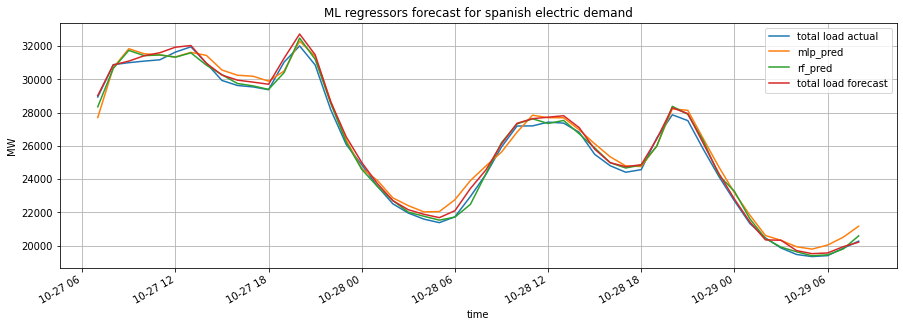

In [122]:
ML_prediction_df.iloc[150:200].plot(x='time', ylabel='MW', title='ML regressors forecast for spanish electric demand', grid=True, figsize=(15,5))
plt.savefig('ML_results.png')

### Pronóstico extendido

Se diseño la siguiente función para realizar predicciones sobre grandes intervalos de pérdida de datos.

In [123]:
import warnings
warnings.filterwarnings("ignore")

In [124]:
def forecast_extended(data, model, forecast_window):
  predictions = np.array([])
  serie_k = data
  # serie_k = data
  # print(serie_k.__len__())
  for k in range(forecast_window):
    serie_k = serie_k.reshape(1,-1)
    prediction = model.predict(serie_k)
    serie_k = np.delete(serie_k, 0)
    serie_k = np.append(serie_k, prediction)
    predictions = np.append(predictions, prediction)

  return predictions

In [129]:
model = rf_regressor
data = X_test.iloc[1].values
forecast_window = 48

predictions_extended = forecast_extended(data=data, model=model, forecast_window=forecast_window)

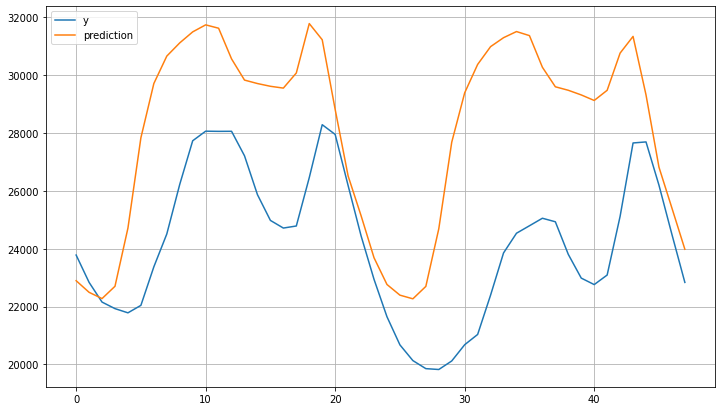

In [130]:
y_extended_test = y_test.iloc[:forecast_window].values
predictions_extended_2 = np.c_[y_extended_test, predictions_extended]

df_predictions_extended = pd.DataFrame(predictions_extended_2, columns=['y', 'prediction'])
df_predictions_extended.plot(grid=True, figsize=(12,7))

## Series Temporales Difusas.

Mediante la representación mostrada en la sección anterior, en esta sección se añade las características de los conjuntos difusos para la obtención de nuevas representaciones de la información de la demanda de la energía.

In [131]:
# Instalación de la librería pyFts, para poder utilizar series temporales difusas.

!pip3 install -U git+https://github.com/PYFTS/pyFTS

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-ti26dhxt
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-ti26dhxt


In [132]:
from pyFTS.partitioners import CMeans, Grid, FCM, Huarng, Entropy, Util as pUtil
from pyFTS.common import Membership as mf
from pyFTS.benchmarks import benchmarks as bchmk

### Caso con data de energía.

In [133]:
# Creando los datasets de entrenamiento y validación.
train_size = .7
train_length = int(train_size*demand_serie.__len__())

# demand_serie['time'] = pd.to_datetime(demand_serie['time'], format='%Y-%m-%d %H:%M:%S')

# Seleccion de datos para el analisis multivariable
features_selected = ['time', 'total load actual', 'total load forecast', 'generation fossil gas',
                     'generation fossil oil', 'generation hydro water reservoir', 'price actual']

demand_data = demand_serie[demand_labels].drop(columns=['total load forecast'], axis=1)
demand_data_2 = demand_serie[features_selected].drop(columns=['total load forecast'], axis=1)

demand_values = demand_data['total load actual'].values

# Conjuntos para análisis inicial.
train_values, test_values = demand_values[:train_length], demand_values[train_length:]
train_df, test_df = demand_data.iloc[:train_length], demand_data.iloc[train_length:]

# Conjuntos de entrenamiento para análisis multivariable.
train_df2, test_df2 = demand_data_2.iloc[:train_length], demand_data_2.iloc[train_length:]

In [134]:
demand_serie.columns

Index(['time', 'total load forecast', 'total load actual',
       'generation fossil gas', 'generation fossil oil',
       'generation hydro water reservoir', 'price day ahead', 'price actual'],
      dtype='object')

In [135]:
print(train_values.shape)
print(test_values.shape)

(24511,)
(10506,)


Ploteo de parte de las series

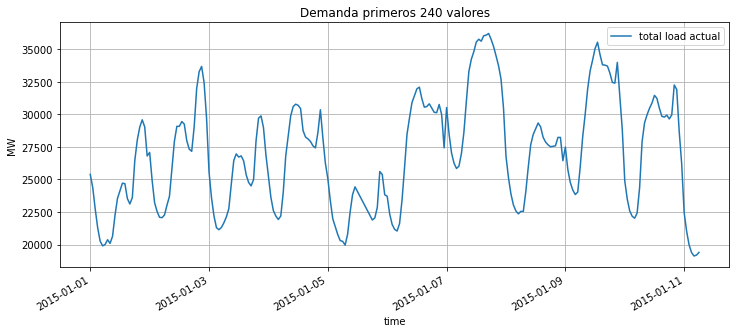

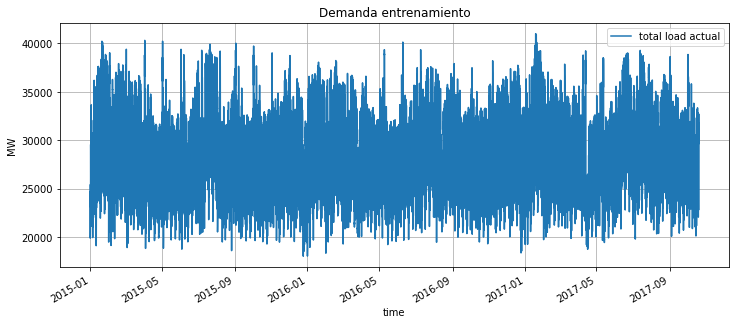

In [136]:
train_df.iloc[:240].plot(x="time", figsize=(12,5), title="Demanda primeros 240 valores", ylabel="MW", grid=True)
train_df.plot(x="time", figsize=(12,5), title="Demanda entrenamiento", ylabel="MW", grid=True)

Text(0.5, 0, 'LAG')

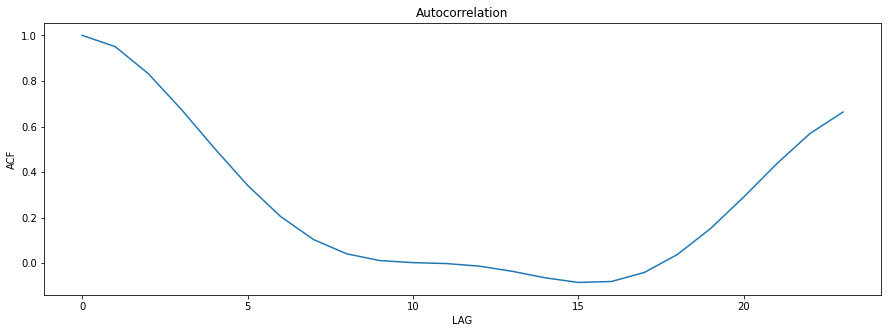

In [137]:
from statsmodels.tsa.stattools import acf

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(acf(train_values,nlags=23))
ax.set_title("Autocorrelation")
ax.set_ylabel("ACF")
ax.set_xlabel("LAG")

###Configuración del tipo de partición.

En estas celdas se configura el tipo de partición que se realiza a la data, se pueden cambiar entre 3 tipos de particiones.

#### Nombres de los niveles de partición

In [138]:
from itertools import product

levels = ['VL','L','M','H','VH']    # Nombres de los niveles que se le aplicara a las particiones
q_levels = 7                        # Cantidad de subniveles.

# Creación de los nombres de las particiones junto con sus subniveles
sublevels = [str(k) for k in np.arange(0,q_levels)]
names = []
for combination in product(*[levels, sublevels]):
  names.append(combination[0]+combination[1])
  
print(names)

['VL0', 'VL1', 'VL2', 'VL3', 'VL4', 'VL5', 'VL6', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'M0', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'VH0', 'VH1', 'VH2', 'VH3', 'VH4', 'VH5', 'VH6']


#### Tipo de Partición

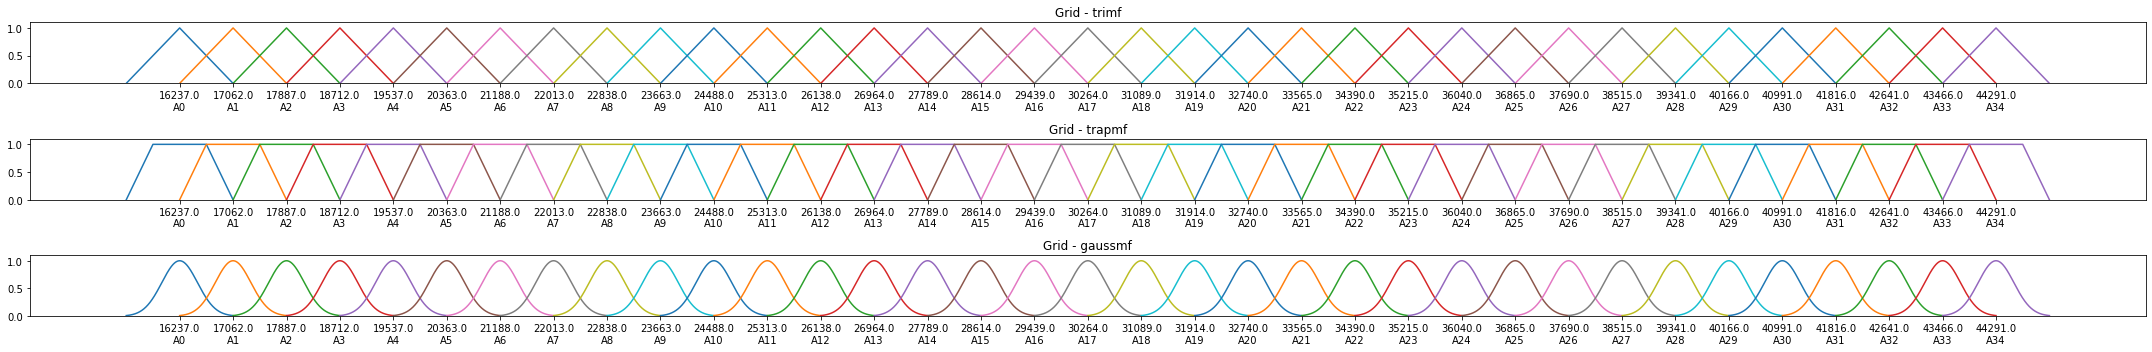

In [139]:
from pyFTS.partitioners import CMeans, Grid, FCM, Huarng, Entropy, Util as pUtil
from pyFTS.common import Membership as mf
from pyFTS.benchmarks import benchmarks as bchmk

# Se configura el GridParitioner con 3 tipos de particiones, triangular, trapezoide y gaussiana.

partitions = pUtil.explore_partitioners(data=train_values, npart=35, methods=[Grid.GridPartitioner],
                                       mf=[mf.trimf, mf.trapmf, mf.gaussmf], size=[30,5], save=True, file='partitions_types.png')

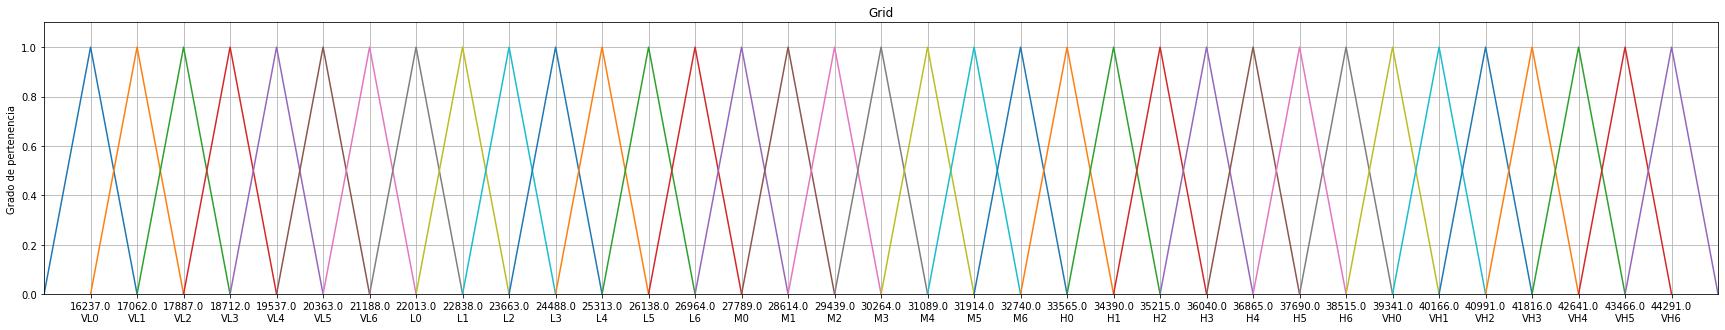

In [140]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[30,5])

part = Grid.GridPartitioner(data=train_values,npart=35, mf=mf.gaussmf, names=names)
# part.membership_function = mf.gaussmf

# part = partitions[0]

part.plot(ax)
plt.ylabel('Grado de pertenencia')
plt.grid(True)
# plt.savefig('partition1.png')

### Entrenamiento de modelos monovariables y multivariables

Seleccionando la partición de los conjuntos, entonces se realiza el entrenamiento de los modelos en las siguientes celdas, cuyos resultados de predicción son guardados en un dataframe.

In [141]:
# Modelos de una sola variable.
from pyFTS.models import hofts, pwfts
from pyFTS.common import Util

# Métricas para el rendimiento de modelos
from pyFTS.benchmarks import Measures

#### Sistema de entrenamiento para series temporales difusas.

El entrenamiento de sistemas monovariables y multivariables es muy similar, por ende se realiza el desarrollo del siguiente objeto para 

In [142]:
class FuzzyTrainer():

  """ 
  Inicializador del objeto.

    data: (pd.DataFrame) Dataframe que contiene los datos a procesar.
    train_size: (float) Valor decimal que contiene el porcentaje de datos que se desea utilizar al realizar el entrenamiento del modelo.
    partition_type: (pyFTS.partitioners) tipo de partición que se le desea aplicar a la data.
    variables_list : (list) Lista que contiene las variables a añadir en caso de que se desee realizar un entrenamiento de la 
                            serie con mas de una variable.

  """

  def __init__(self, data, target, train_size, partition_type=Grid.GridPartitioner, variables_list=[]):
    self.data = data
    self.partition_type = partition_type
    self.variables_list = variables_list
    train_length = int(data.__len__() * train_size)

    # Separando los datos del conjunto de entrenamiento y prueba dependiendo del tipo de modelo que se utilice
    if variables_list.__len__() == 0:
      data_values = data[target].values
      self.train_data = data_values[:train_length]
      self.test_data = data_values[train_length:]
    else:
      self.train_data = data.iloc[:train_length]
      self.test_data = data.iloc[train_length:]


  """ 
  fit_single. Este metodo se usa para entrenar modelos que solo posean una sola variable.

    model: (pyFTS.models) modelo de pyFTS que se desea entrenar. Este ya debe venir inicializado
    save_local: (bool) Valor booleano que indica si se desea guardar el modelo.
    
  """
  def fit_single(self, model, order, save_local=True):

    model = model(partitioner = self.partition_type, order=order)
    model.shortname += str(order)

    
    model.fit(self.train_data)

    if save_local:
      Util.persist_obj(model, model.shortname)
    else:
      pass
    self.model = model
    self.order = order

  """ 
  fit_multi. Si se tiene un regresor difuso multivariable, entonces se debe utilizar este metodo para realizar el entrenamiento del modelo

    model: (pyFTS.models) modelo de pyFTS que se desea entrenar, este ya debe venir inicializado.
    target_variable (pyFTS.models.multivariate.variable) variable de interes que contiene los datos que se quieren analizar.
    save_local: (bool) Valor booleano que indica si se desea guardar el modelo.
  """
  def fit_multi(self, model, target_variable, save_local=True):
    for variable in self.variables_list:
      model.append_variable(variable)

    model.target_variable = target_variable
    model.fit(self.train_data)
    if save_local:
      Util.persist_obj(model, model.shortname)
    else:
      pass
    self.model = model


  def predict(self, data, dropna=False):
    predictions = list(self.model.predict(data))
    # if delete_model:
    #   del(self.model)
    if dropna or predictions.__len__() == self.test_data.__len__():
      return predictions
    else:
      k = 0
      delta_pred = self.test_data.__len__() - predictions.__len__()
      while k < delta_pred:
        predictions.insert(0, np.nan)
        k += 1
      return predictions

#### Modelos con variable única.

En las siguientes celdas se tienen diversos modelos que solo tienen en cuenta la variable de interes.

In [143]:
models_single = [hofts.HighOrderFTS, hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]

# Inicializador del objeto de entrenamiento

data = demand_data
target = 'total load actual'
train_size = .7

generate_dict_single = True     # Decidiendo si se desea obtener el diccionario con las predicciones de los regresores con 1 variable
# partitions = [part]

In [144]:
if generate_dict_single:

  # Tipos de particiones cargadas

  grid_types = ['tri', 'trap', 'gauss']
  predictions_single_dict = dict()    # Diccionario para guardar los dataframes con las predicciones segun el tipo de partición.
  # part = partition[2]

  # Variables para almacenar los datos obtenidos por los modelos

  for k, part in enumerate(partitions):
    partition_name = 'GridPartitioner_' + grid_types[k]
    print('Process Fuzzy regressor, one variable. partitioner: ' + partition_name)
    prediction_df = test_df.copy()
    fuzzy_single_trainer = FuzzyTrainer(data=data, target=target, train_size=train_size, partition_type=part)

    for method in models_single:
      for order in [1,2,3]:
        print('Order model: ', order)
        fuzzy_single_trainer.fit_single(model=method, order=order)
        prediction_df[fuzzy_single_trainer.model.shortname] = fuzzy_single_trainer.predict(test_values)

    predictions_single_dict[partition_name] = prediction_df
    print('Predictions saved!')
    print('--------------')
    del(prediction_df)
    del(fuzzy_single_trainer)

  pickle.dump(predictions_single_dict, open('predictions_single_dict.pickle', 'wb'))  # Guardando el diccionario generado.

else:
  predictions_single_dict = pickle.load(open(directory_var + 'predictions_single_dict.pickle', 'rb'))

Process Fuzzy regressor, one variable. partitioner: GridPartitioner_tri
Order model:  1
Order model:  2
Order model:  3
Order model:  1
Order model:  2
Order model:  3
Order model:  1
Order model:  2
Order model:  3
Predictions saved!
--------------
Process Fuzzy regressor, one variable. partitioner: GridPartitioner_trap
Order model:  1
Order model:  2
Order model:  3
Order model:  1
Order model:  2
Order model:  3
Order model:  1
Order model:  2
Order model:  3
Predictions saved!
--------------
Process Fuzzy regressor, one variable. partitioner: GridPartitioner_gauss
Order model:  1
Order model:  2
Order model:  3
Order model:  1
Order model:  2
Order model:  3
Order model:  1
Order model:  2
Order model:  3
Predictions saved!
--------------


In [1]:
models_show = ['time', 'total load actual', 'PWFTS3', 'PWFTS2', 'PWFTS1']

In [45]:
predictions_single_dict.keys()

dict_keys(['GridPartitioner_tri', 'GridPartitioner_trap', 'GridPartitioner_gauss'])

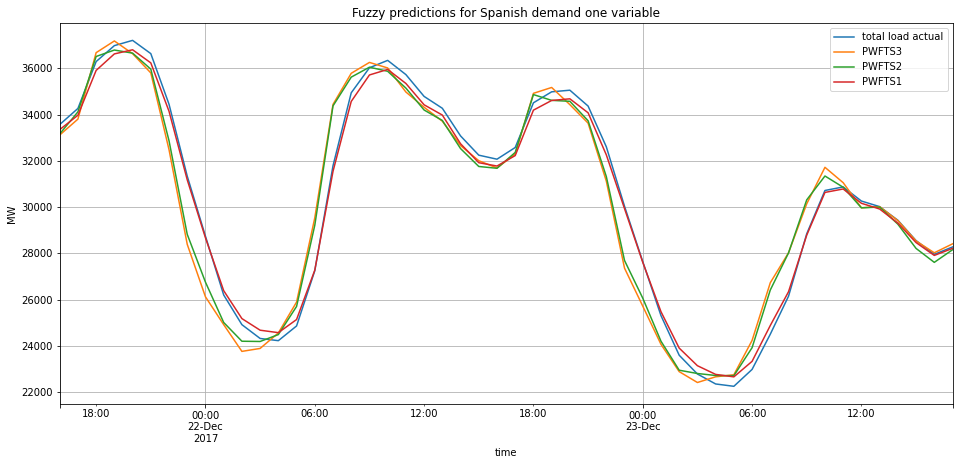

In [ ]:
pred_single_test = predictions_single_dict['GridPartitioner_tri']
pred_single_test[models_show].iloc[1500:1550].plot(x='time', ylabel='MW', title='Fuzzy predictions for Spanish demand one variable', grid=True, figsize=(16,7))
# plt.savefig('PWFTS_results.png')

#### Modelos de varias variables

Se pueden incorporar diversas variables dentro del análisis al momento de realizar el entrenamiento de los regresores con series difusas

In [ ]:
# Creando los datasets de entrenamiento y validación.
train_size = .7
train_length = int(train_size*demand_serie.__len__())

features_selected = ['time', 'total load actual', 'total load forecast', 'generation fossil gas',
                     'generation fossil oil', 'generation hydro water reservoir', 'price actual']

features_selected = ['time','total load actual', 'total load forecast', 'generation fossil gas',
                     'generation fossil oil', 'generation hydro water reservoir']

demand_data_2 = demand_serie[features_selected].drop(columns=['total load forecast'], axis=1)

# Conjuntos de entrenamiento para análisis multivariable.
train_df2, test_df2 = demand_data_2.iloc[:train_length], demand_data_2.iloc[train_length:]

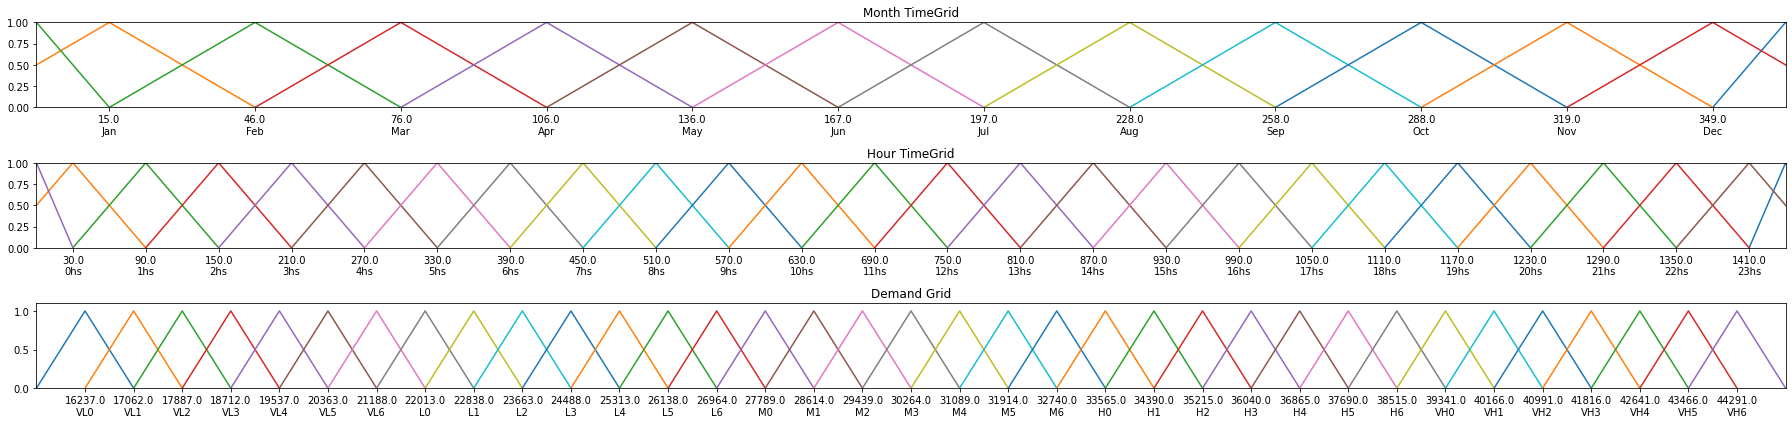

In [ ]:
from pyFTS.models.seasonal.common import DateTime
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[25,6])


# Partición del tiempo para añadirlas a los modelos.

train_df = train_df

sp = {'seasonality': DateTime.day_of_year , 'names': ['Jan','Feb','Mar','Apr','May',
                                                      'Jun','Jul', 'Aug','Sep','Oct',
                                                      'Nov','Dec']}

# Mes
vmonth = variable.Variable("Month", data_label="time", partitioner=seasonal.TimeGridPartitioner, npart=12, 
                           data=train_df, partitioner_specific=sp)

vmonth.partitioner.plot(ax[0])


sp = {'seasonality': DateTime.minute_of_day, 'names': [str(k)+'hs' for k in range(0,24)]}

# Hora
vhour = variable.Variable("Hour", data_label="time", partitioner=seasonal.TimeGridPartitioner, npart=24, 
                          data=train_df, partitioner_specific=sp) 

vhour.partitioner.plot(ax[1])

# Demanda
vavg = variable.Variable("Demand", data_label="total load actual", alias='dem',
                         partitioner=Grid.GridPartitioner, npart=35, partitioner_specific={'names': names},  
                         data=train_df) 

vavg.partitioner.plot(ax[2])

plt.tight_layout()
plt.savefig('partition_time.png')

In [ ]:
from pyFTS.models.multivariate import mvfts, wmvfts, granular

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])

generate_pred_multi_df = True    # Se decide si se desea entrenar el modelo.

if generate_pred_multi_df:
  parameters = [
      {},{},
      {'order':2, 'knn': 1},
      {'order':2, 'knn': 2},
      {'order':2, 'knn': 3},
  ]

  # Modelos que se desean utilizar.

  models_multi = [mvfts.MVFTS, wmvfts.WeightedMVFTS, granular.GranularWMVFTS,granular.GranularWMVFTS,granular.GranularWMVFTS]
  # models_multi = [granular.GranularWMVFTS, granular.GranularWMVFTS, granular.GranularWMVFTS]
  # models_multi = [granular.GranularWMVFTS]

  # Inicializador del objeto de entrenamiento

  data = demand_data
  target = 'total load actual'
  train_size = .7
  variables_list = [vmonth, vhour, vavg]

  fuzzy_multi_trainer = FuzzyTrainer(data=data, target=target, train_size=train_size, variables_list=variables_list)

  # Dataframe con los valores de las predicciones de los modelos multivariables
  predictions_multi_df = test_df2.copy()

  # ax.plot(test_values[:100],label='demand')

  for ct, method in enumerate(models_multi):
    try:
      model = method(**parameters[ct])
      model.shortname += str(ct)
      fuzzy_multi_trainer.fit_multi(model, vavg)
      predictions_multi_df[model.shortname] = fuzzy_multi_trainer.predict(test_df)
      del(model)

    except Exception as ex:
      print(key, method, parameters[ct2])
      print(ex)

  predictions_multi_df.to_csv('predictions_multi_df.csv')   # Guardando el dataframe generado.

else:
  predictions_multi_df = pd.read_csv(directory_var + 'predictions_multi_df.csv', index_col='Unnamed: 0')

File FIG-FTS2 could not be saved due exception maximum recursion depth exceeded while calling a Python object
File FIG-FTS3 could not be saved due exception maximum recursion depth exceeded while calling a Python object
File FIG-FTS4 could not be saved due exception maximum recursion depth exceeded while calling a Python object


In [ ]:
# multi_cols = ['time','total load actual','FIG-FTS1','FIG-FTS2','FIG-FTS3']

In [ ]:
# preds_multi_df[multi_cols].iloc[1500:1550].plot(x='time', ylabel='MW', title='Fuzzy predictions multivariable for Spanish demand', 
#                                                 grid=True, figsize=(16,7))

# plt.savefig('FIG-FTS_results.png')

### Rendimiento de los modelos obtenidos

Utilizando las métricas del RMSE y MAPE se Rankean los modelos experimentados. Para ello se utiliza la siguiente función.

In [46]:
# Función para el cálculo de métricas de rendimiento de diversos modelos.

def regression_metrics(df, target_column, is_multivariate=False, partition_type='GridPartitioner'):
  y_true = df[target_column].values
  df_process = df.drop(columns=['time', target_column], axis=1)
  df_metrics = pd.DataFrame()
  df_metrics['model'] = df_process.columns
  rmse_list, mape_list = [], []
  for model in df_process.columns:
    forecast_values = df_process[model].values
    RMSE = Measures.rmse(y_true, forecast_values)
    MAPE = Measures.mape(y_true, forecast_values)
    rmse_list.append(RMSE)
    mape_list.append(MAPE)

  model_type = ['multi'] if is_multivariate else ['single']
  df_metrics['model_type'] = model_type * df_process.columns.__len__()
  df_metrics['data_partition'] = [partition_type] * df_process.columns.__len__()
  df_metrics['RMSE'] = rmse_list
  df_metrics['MAPE'] = mape_list

  return df_metrics

Aplicando la función anterior a las predicciones obtenidas anteriormente

In [47]:
partitions_single = list(predictions_single_dict.keys())
default_df = demand_serie.loc[predictions_single_dict['GridPartitioner_tri'].index]


# Obteniendo los valores del rmse y mape de las predicciones que vinieron por default en el dataset.
default_rmse = round(Measures.rmse(default_df['total load actual'], default_df['total load forecast']), 3)
default_mape = Measures.mape(default_df['total load actual'], default_df['total load forecast'])
default_metrics = np.array(['work_model', '-', '-', default_rmse, default_mape]).reshape(1,5)

# Inicializando el dataframe con los valores anteriores.
metrics_single_df = pd.DataFrame(default_metrics, columns=['model', 'model_type', 'data_partition', 'RMSE', 'MAPE'])

for part_name in partitions_single:
  prediction_df = predictions_single_dict[part_name]
  metrics_df = regression_metrics(prediction_df.dropna(), 'total load actual', partition_type=part_name)
  metrics_single_df = pd.concat([metrics_single_df, metrics_df], axis=0)

# Como los primeros valores fueron una lista variada, entonces se debe cambiar el tipo de dato presente en la columna MAPE.
metrics_single_df = metrics_single_df.astype({'MAPE': float})
metrics_single_df.sort_values('MAPE').reset_index()

,index,model,model_type,data_partition,RMSE,MAPE
0,0,work_model,-,-,399.662,0.959025
1,6,PWFTS1,single,GridPartitioner_gauss,650.403104,1.841831
2,6,PWFTS1,single,GridPartitioner_tri,740.623382,1.909078
3,7,PWFTS2,single,GridPartitioner_tri,712.268267,1.932035
4,7,PWFTS2,single,GridPartitioner_gauss,700.050044,2.021739
5,8,PWFTS3,single,GridPartitioner_tri,754.583481,2.160858
6,7,PWFTS2,single,GridPartitioner_trap,797.208488,2.189037
7,6,PWFTS1,single,GridPartitioner_trap,841.322473,2.222782
8,8,PWFTS3,single,GridPartitioner_trap,812.789976,2.228696
9,8,PWFTS3,single,GridPartitioner_gauss,830.394348,2.411481


In [ ]:
multi_metrics = regression_metrics(predictions_multi_df.dropna(), 'total load actual', is_multivariate=True)
multi_metrics.sort_values('MAPE')

,model,model_type,data_partition,RMSE,MAPE
6,FIG-FTS3,multi,GridPartitioner,657.422730,1.542152
7,FIG-FTS4,multi,GridPartitioner,670.521618,1.586401
5,FIG-FTS2,multi,GridPartitioner,705.020650,1.703612
4,WeightedMVFTS1,multi,GridPartitioner,1258.927305,3.482089
3,MVFTS0,multi,GridPartitioner,1307.158328,3.608678
0,generation fossil gas,multi,GridPartitioner,23307.765245,79.355292
2,generation hydro water reservoir,multi,GridPartitioner,26718.251560,91.124990
1,generation fossil oil,multi,GridPartitioner,29123.039311,99.009468


In [ ]:
multi_metrics = regression_metrics(predictions_multi_df.dropna(), 'total load actual', is_multivariate=True)
multi_metrics.sort_values('MAPE')

,model,model_type,data_partition,RMSE,MAPE
6,FIG-FTS3,multi,GridPartitioner,657.422730,1.542152
7,FIG-FTS4,multi,GridPartitioner,670.521618,1.586401
5,FIG-FTS2,multi,GridPartitioner,705.020650,1.703612
4,WeightedMVFTS1,multi,GridPartitioner,1258.927305,3.482089
3,MVFTS0,multi,GridPartitioner,1307.158328,3.608678
0,generation fossil gas,multi,GridPartitioner,23307.765245,79.355292
2,generation hydro water reservoir,multi,GridPartitioner,26718.251560,91.124990
1,generation fossil oil,multi,GridPartitioner,29123.039311,99.009468


In [ ]:
# Concatenando las metricas obtenidas para ambos tipos de modelos

grid_metrics = pd.concat([metrics_single_df, multi_metrics], axis=0)
metrics_final = grid_metrics.sort_values('MAPE')
metrics_final.reset_index(drop=True, inplace=True)
metrics_final

,model,model_type,data_partition,RMSE,MAPE
0,PWFTS1,single,GridPartitioner_tri,279.556142,0.873876
1,PWFTS1,single,GridPartitioner_gauss,285.202733,0.877954
2,PWFTS1,single,GridPartitioner_trap,288.521371,0.885159
3,work_model,-,-,399.662,0.959025
4,FIG-FTS3,multi,GridPartitioner,657.42273,1.542152
5,FIG-FTS4,multi,GridPartitioner,670.521618,1.586401
6,FIG-FTS2,multi,GridPartitioner,705.02065,1.703612
7,WHOFTS3,single,GridPartitioner_tri,926.525288,2.335932
8,WHOFTS3,single,GridPartitioner_trap,926.525288,2.335932
9,PWFTS2,single,GridPartitioner_trap,909.794054,2.393681


### Seleccion especifica de modelo a evaluar.


In [ ]:
# partition = Grid.GridPartitioner(data=train_values,npart=35, mf=mf.trimf, names=names)
# model = pwfts.ProbabilisticWeightedFTS(partitioner = partition, order = 1)
# print("Training fuzzy regressor, model: " + model.shortname)

data = demand_data
target = 'total load actual'
train_size = .7

In [ ]:
partition = Grid.GridPartitioner(data=train_values,npart=35, mf=mf.trimf, names=names)
print("Training fuzzy regressor")

fuzzy_single_trainer = FuzzyTrainer(data=data, target=target, train_size=train_size, partition_type=part)

prediction_df = test_df.copy()

for order in range(1,4):
  method = pwfts.ProbabilisticWeightedFTS
  print("model PWFTS:  , order: " + str(order))
  fuzzy_single_trainer.fit_single(model=method, order=order)
  prediction_df[fuzzy_single_trainer.model.shortname] = fuzzy_single_trainer.predict(test_values)


print('Predictions saved!')
print('--------------')

Training fuzzy regressor
model PWFTS:  , order: 1
model PWFTS:  , order: 2
model PWFTS:  , order: 3
Predictions saved!
--------------


####Prediccion para las siguientes 48 horas

[Errno 2] No such file or directory: 'FIG-FTS0'
[Errno 2] No such file or directory: 'FIG-FTS1'
Ran out of input


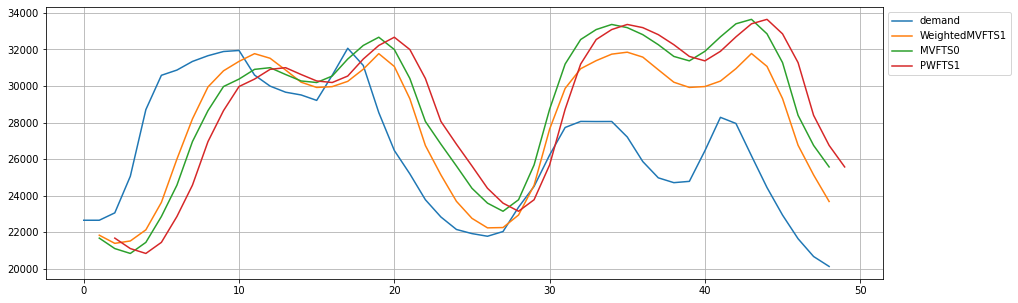

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])

ax.plot(test_values[:49],label='demand')

generator = lambda x : x + pd.to_timedelta(1, unit='h') 

models = ['WeightedMVFTS1', 'MVFTS0','FIG-FTS0', 'FIG-FTS1', 'FIG-FTS2', 'PWFTS1']

for file in models:
  try:
    model = Util.load_obj(file)
    
    if file == 'PWFTS1':
      forecast = model.predict(test_values[:1], steps_ahead=48, generators={'time':generator})

    else:
      forecasts = model.predict(test_df.iloc[:1], steps_ahead=48, 
                              generators={'time': generator})

    for k in np.arange(model.order):
      forecasts.insert(0,None)

    ax.plot(forecasts, label=model.shortname)
  except Exception as ex:
    print(ex)
  
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.grid(True)

In [ ]:
test_df.iloc[:1]

,time,total load actual
24511,2017-10-20 03:00:00+02:00,22658.0


## Replicación de modelos del estado del arte.

En esta sección de muestran una adaptación de una serie de modelos de estado del arte para la predicción de demanda de energía eléctrica. En primer lugar se realizara un pequeño preprocesamiento de datos.

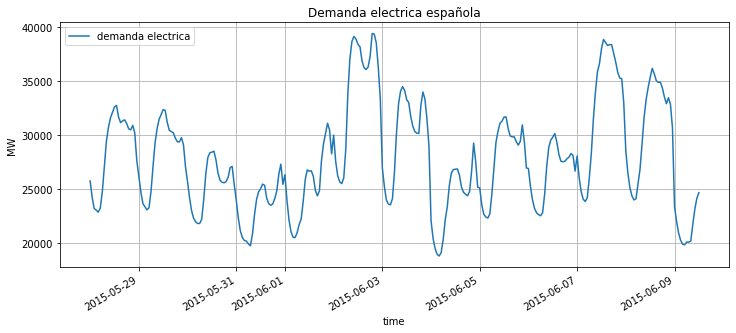

In [ ]:
data_plot = data.rename(columns={'total load actual':'demanda electrica'})
data_plot.iloc[3500:3800].plot(x='time', figsize=(12,5), grid=True, title='Demanda electrica española', ylabel='MW')
plt.savefig('image_2_marco.png')

### Prediccion para ventanas amplias (48 horas)